<a href="https://colab.research.google.com/github/zhangxs131/paper_demo_for_fun/blob/main/text2image_glide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##GLIDE

使用Open AI 的GLIDE模型进行文字到图片的生成任务

项目地址：https://github.com/openai/glide-text2im

论文：https://arxiv.org/abs/2112.10741

In [1]:
#安装依赖，这里github直接包含setup
!pip install git+https://github.com/openai/glide-text2im

  Cloning https://github.com/openai/glide-text2im to /tmp/pip-req-build-s_zmum7e
  Running command git clone -q https://github.com/openai/glide-text2im /tmp/pip-req-build-s_zmum7e
     |████████████████████████████████| 53 kB 971 kB/s 
  Created wheel for glide-text2im: filename=glide_text2im-0.0.0-py3-none-any.whl size=1953663 sha256=95d1712329b090905c4909b7619010bb2a870edb4d10a42591a0ff1fc26b6b77
  Stored in directory: /tmp/pip-ephem-wheel-cache-bsaatvqe/wheels/b4/36/07/46711fd6462da277046c6720504e61546b6e32adc0293abc96
Successfully built glide-text2im


In [3]:
from PIL import Image
from IPython.display import display
import torch as th

from glide_text2im.download import load_checkpoint
from glide_text2im.model_creation import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
    model_and_diffusion_defaults_upsampler
)

##查看是否使用GPU

In [4]:
has_cuda = th.cuda.is_available()
device = th.device('cpu' if not has_cuda else 'cuda')

##加载扩散模型

In [5]:
options = model_and_diffusion_defaults()
options['use_fp16'] = has_cuda
options['timestep_respacing'] = '100' # use 100 diffusion steps for fast sampling
model, diffusion = create_model_and_diffusion(**options)
model.eval()
if has_cuda:
    model.convert_to_fp16()
model.to(device)
model.load_state_dict(load_checkpoint('base', device))
print('total base parameters', sum(x.numel() for x in model.parameters()))

  0%|          | 0.00/1.54G [00:00<?, ?iB/s]

total base parameters 385030726


##加载上采样模型

In [6]:
# Create upsampler model.
options_up = model_and_diffusion_defaults_upsampler()
options_up['use_fp16'] = has_cuda
options_up['timestep_respacing'] = 'fast27' # use 27 diffusion steps for very fast sampling
model_up, diffusion_up = create_model_and_diffusion(**options_up)
model_up.eval()
if has_cuda:
    model_up.convert_to_fp16()
model_up.to(device)
model_up.load_state_dict(load_checkpoint('upsample', device))
print('total upsampler parameters', sum(x.numel() for x in model_up.parameters()))

  0%|          | 0.00/1.59G [00:00<?, ?iB/s]

total upsampler parameters 398361286


##图片显示函数

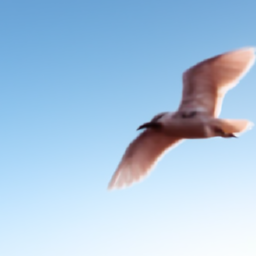

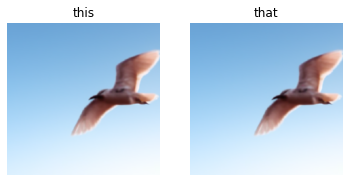

In [18]:
import matplotlib.pyplot as plt

def show_images(batch: th.Tensor,prompt=None):
    """ Display a batch of images inline. """
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    im=reshaped.numpy()
    display(Image.fromarray(reshaped.numpy()))


##设置参数和prompt文本

In [11]:
# 采样参数
prompt = "the bird in the sky"
batch_size = 1
guidance_scale = 3.0

# Tune this parameter to control the sharpness of 256x256 images.
# A value of 1.0 is sharper, but sometimes results in grainy artifacts.
upsample_temp = 0.997

##从base model进行上采样，得到生成图片

  0%|          | 0/100 [00:00<?, ?it/s]

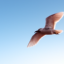

In [12]:
# Create the text tokens to feed to the model.
tokens = model.tokenizer.encode(prompt)
tokens, mask = model.tokenizer.padded_tokens_and_mask(
    tokens, options['text_ctx']
)

# Create the classifier-free guidance tokens (empty)
full_batch_size = batch_size * 2
uncond_tokens, uncond_mask = model.tokenizer.padded_tokens_and_mask(
    [], options['text_ctx']
)

# Pack the tokens together into model kwargs.
model_kwargs = dict(
    tokens=th.tensor(
        [tokens] * batch_size + [uncond_tokens] * batch_size, device=device
    ),
    mask=th.tensor(
        [mask] * batch_size + [uncond_mask] * batch_size,
        dtype=th.bool,
        device=device,
    ),
)

# Create a classifier-free guidance sampling function
def model_fn(x_t, ts, **kwargs):
    half = x_t[: len(x_t) // 2]
    combined = th.cat([half, half], dim=0)
    model_out = model(combined, ts, **kwargs)
    eps, rest = model_out[:, :3], model_out[:, 3:]
    cond_eps, uncond_eps = th.split(eps, len(eps) // 2, dim=0)
    half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
    eps = th.cat([half_eps, half_eps], dim=0)
    return th.cat([eps, rest], dim=1)

# Sample from the base model.
model.del_cache()
samples = diffusion.p_sample_loop(
    model_fn,
    (full_batch_size, 3, options["image_size"], options["image_size"]),
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
)[:batch_size]
model.del_cache()

# Show the output
show_images(samples)

##从64*64样本中上采样得到图片

  0%|          | 0/27 [00:00<?, ?it/s]

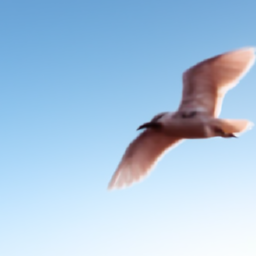

In [13]:
tokens = model_up.tokenizer.encode(prompt)
tokens, mask = model_up.tokenizer.padded_tokens_and_mask(
    tokens, options_up['text_ctx']
)

# Create the model conditioning dict.
model_kwargs = dict(
    # Low-res image to upsample.
    low_res=((samples+1)*127.5).round()/127.5 - 1,

    # Text tokens
    tokens=th.tensor(
        [tokens] * batch_size, device=device
    ),
    mask=th.tensor(
        [mask] * batch_size,
        dtype=th.bool,
        device=device,
    ),
)

# Sample from the base model.
model_up.del_cache()
up_shape = (batch_size, 3, options_up["image_size"], options_up["image_size"])
up_samples = diffusion_up.ddim_sample_loop(
    model_up,
    up_shape,
    noise=th.randn(up_shape, device=device) * upsample_temp,
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
)[:batch_size]
model_up.del_cache()

# Show the output
show_images(up_samples)

In [39]:
def generate(prompts):
  length=len(prompts)
  result=[]

  # Create the classifier-free guidance tokens (empty)
  full_batch_size = batch_size * 2
  uncond_tokens, uncond_mask = model.tokenizer.padded_tokens_and_mask(
        [], options['text_ctx']
    )
  # Create a classifier-free guidance sampling function
  def model_fn(x_t, ts, **kwargs):
        half = x_t[: len(x_t) // 2]
        combined = th.cat([half, half], dim=0)
        model_out = model(combined, ts, **kwargs)
        eps, rest = model_out[:, :3], model_out[:, 3:]
        cond_eps, uncond_eps = th.split(eps, len(eps) // 2, dim=0)
        half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
        eps = th.cat([half_eps, half_eps], dim=0)
        return th.cat([eps, rest], dim=1)

  for prompt in prompts:
    # tokenizer
    tokens = model.tokenizer.encode(prompt)
    tokens, mask = model.tokenizer.padded_tokens_and_mask(
        tokens, options['text_ctx']
    )
   

    # Pack the tokens together into model kwargs.
    model_kwargs = dict(
        tokens=th.tensor(
            [tokens] * batch_size + [uncond_tokens] * batch_size, device=device
        ),
        mask=th.tensor(
            [mask] * batch_size + [uncond_mask] * batch_size,
            dtype=th.bool,
            device=device,
        ),
    )



    # Sample from the base model.
    model.del_cache()
    batch = diffusion.p_sample_loop(
        model_fn,
        (full_batch_size, 3, options["image_size"], options["image_size"]),
        device=device,
        clip_denoised=True,
        progress=True,
        model_kwargs=model_kwargs,
        cond_fn=None,
    )[:batch_size]
    model.del_cache()

    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    result.append(reshaped.numpy())

  show_img(result,prompts)


def show_img(results,prompt=None):

    length=len(results)

    t=length//3+1 if length%3!=0 else length//3
    plt.figure(figsize=(16,16))

    i=0
    while i<length:
      plt.subplot(t,3,i+1)
      plt.imshow(results[i])
      plt.title(prompt[i])
      plt.axis('off')

      i+=1

    plt.show()



  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

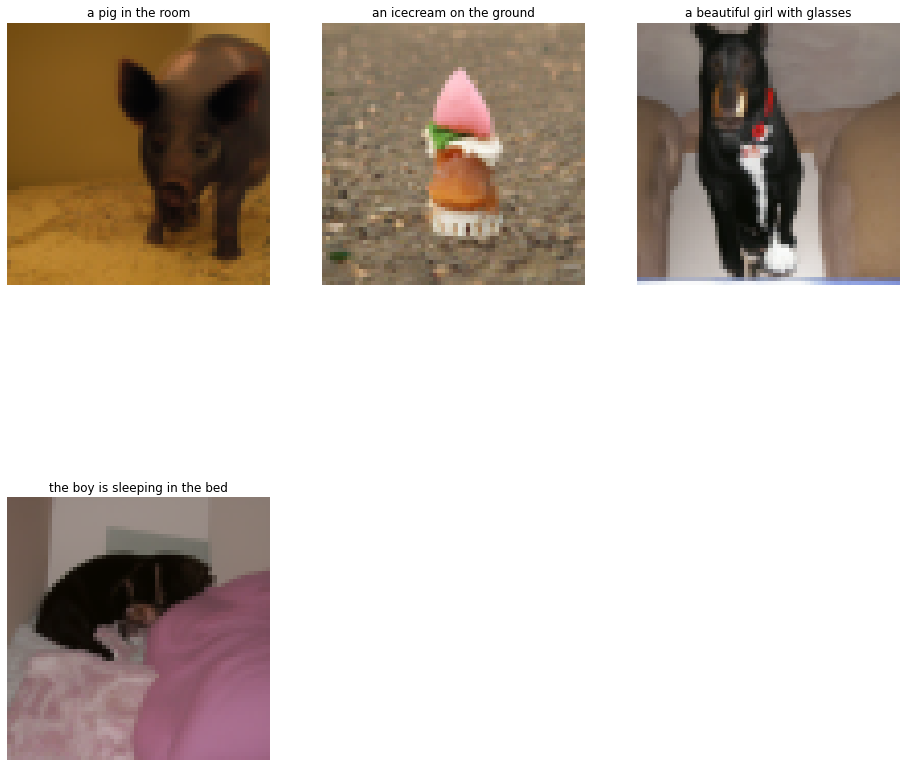

In [40]:
text=['a pig in the room','an icecream on the ground','a beautiful girl with glasses','the boy is sleeping in the bed']
generate(text)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

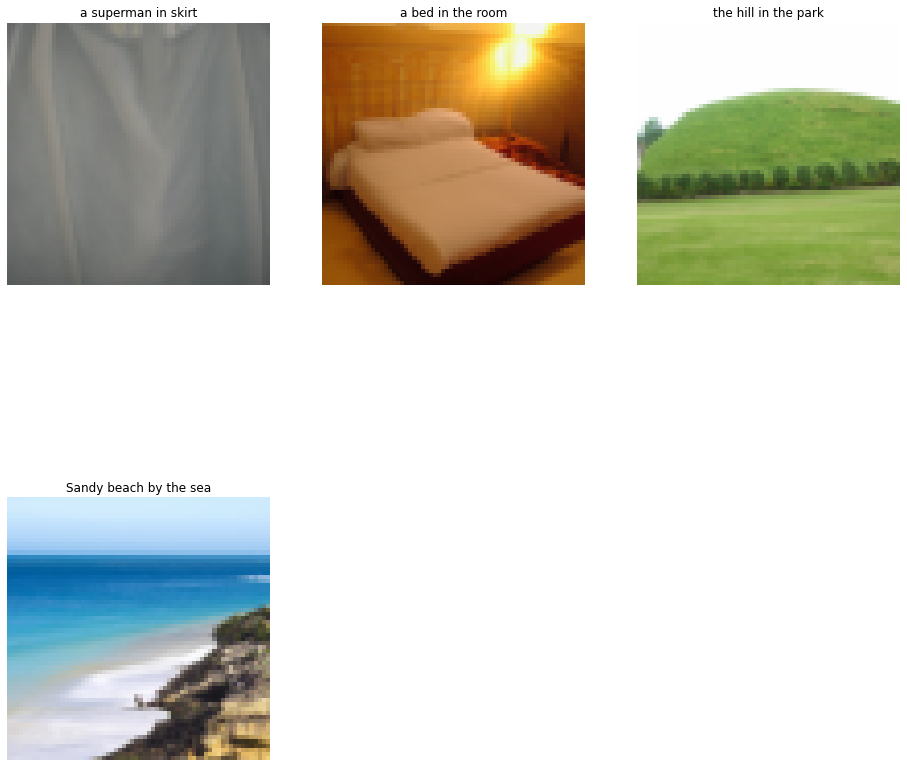

In [41]:
text=['a superman in skirt','a bed in the room','the hill in the park','Sandy beach by the sea']
generate(text)